In [50]:
import pandas as pd
import numpy as np
import tensorflow as tf
import imageio
import os
import time
import math
import random
# import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## Loading the dataset

In [11]:
(X_train, Y_train), (X_test, Y_test) = tf.keras.datasets.mnist.load_data()

NameError: name 'tfds' is not defined

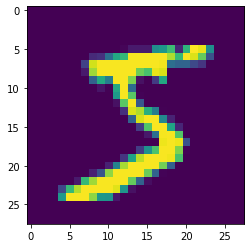

In [28]:
input = np.array(X_train[0])

plt.imshow(input)
plt.show()

In [29]:
# Parameters
image_train_time = 350

min_frequency = 1
max_frequency = 50

In [30]:
def encode_image_to_spike_train(image: np.ndarray):
    spike_trains = []

    for x_position in range(image.shape[0]):
        for y_position in range(image.shape[1]):

            pixel_value = image[x_position][y_position]

            spike_train = np.zeros(shape=(image_train_time+1,))

            # Transfer pixel value to set frequency range(and some other stuff, which interp does...)
            frequency = np.interp(pixel_value, [np.min(image),np.max(image)], [min_frequency,max_frequency])

            spike_time_distance = math.ceil(image_train_time / frequency)
            next_spike_time = spike_time_distance

            if pixel_value > 0:
                while next_spike_time < image_train_time + 1:
                    # Add Spike to Spike Train
                    spike_train[int(next_spike_time)] = 1

                    # Calculate next spike
                    next_spike_time += spike_time_distance

            spike_trains.append(spike_train)

    return spike_trains


In [31]:
encode_image_to_spike_train(input)

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 

In [32]:
def receptive_field(image: np.ndarray):
    image_size_x = image.shape[0]
    image_size_y = image.shape[1]

    weight1 =  0.625
    weight2 =  0.125
    weight3 = -0.125
    weight4 = -.5

    # Receptive Field Kernel
    receptive_field = [
        [weight4 ,weight3 , weight2 ,weight3 ,weight4],
        [weight3 ,weight2 , weight1 ,weight2 ,weight3],
        [ weight2 ,weight1 ,   1    ,weight1 ,weight2],
        [weight3 ,weight2 , weight1 ,weight2 ,weight3],
        [weight4 ,weight3 , weight2 ,weight3 ,weight4]]

    convoluted_image = np.zeros(image.shape)

    window = [-2,-1,0,1,2]
    x_offset = 2
    y_offset = 2

    # Apply Convolution with Receptive Field Kernel
    for x_image_index in range(image_size_x):
        for y_image_index in range(image_size_y):
            summation = 0
            for x_kernel_index in window:
                for y_kernel_index in window:
                    if (x_image_index+x_kernel_index)>=0 and (x_image_index+x_kernel_index)<=image_size_x-1 and (y_image_index+y_kernel_index)>=0 and (y_image_index+y_kernel_index)<=image_size_y-1:
                        summation = summation + (receptive_field[x_offset+x_kernel_index][y_offset+y_kernel_index] * image[x_image_index+x_kernel_index][y_image_index+y_kernel_index]) / 255
            convoluted_image[x_image_index][y_image_index] = summation
    return convoluted_image


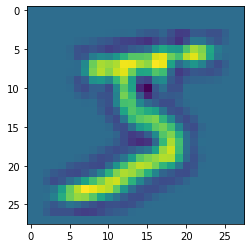

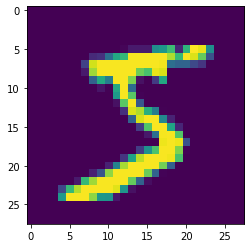

In [36]:
receptive_field_output = receptive_field(input)

plt.imshow(receptive_field_output)
plt.show()
plt.imshow(input)
plt.show()

In [45]:
# Simulation Parameters
time_of_learning = 350 #Training time for every image
past_window = -5
epochs = 1

# Input Parameters
training_set_path= "./mnist_png/training/"
image_size = (28,28)
resting_potential = -70
layer1_size = image_size[0] * image_size[1] # Number of neurons in first layer
layer2_size =  800  # Number of neurons in second layer

# Neuron Parameters
inhibitory_potential = -100
spike_threshold = -55
hyperpolarization_potential = -90
spike_drop_rate = 0.8
threshold_drop_rate = 0.4
min_weight = 0.00001
max_weight = 1.0

# STDP Parameters
STDP_offset = 0
sigma = 0.01
A_plus = 0.8
A_minus = 0.8
tau_plus = 5
tau_minus = 5
mu=0.9

In [46]:
class Neuron:
	def hyperpolarization(self, time_step):
		self.P = hyperpolarization_potential
		self.rest_until = time_step + self.refractory_period

	def inhibit(self, time_step):
		self.P = inhibitory_potential
		self.rest_until = time_step + self.refractory_period

	def initial(self):
		self.adaptive_spike_threshold = spike_threshold
		self.rest_until = -1
		self.refractory_period = 15 #(us)
		self.potential = resting_potential

In [47]:
# STDP reinforcement learning curve
def STDP_weighting_curve(time_step: int):
	if time_step>0:
		return -A_plus*(np.exp(-float(time_step)/tau_plus)-STDP_offset)
	if time_step<=0:
		return A_minus*(np.exp(float(time_step)/tau_minus)-STDP_offset)


# STDP weight update rule
def update_synapse(synapse_weight, weight_factor):
	if weight_factor<0:
		return synapse_weight + sigma * weight_factor * (synapse_weight - abs(min_weight))**mu
	elif weight_factor>0:
		return synapse_weight + sigma * weight_factor * (max_weight - synapse_weight)**mu

In [48]:
def reconst_weights(weights, num):
	weights = np.array(weights)
	weights = np.reshape(weights, image_size)
	img = np.zeros(image_size)
	for i in range(layer1_size):
		for j in range(layer2_size):
			img[i][j] = int(np.interp(weights[i][j], [min_weight, max_weight], [0,255]))

	imageio.imwrite('neuron_' + str(num) + '.png' ,img.astype(np.uint8))
	return img

In [56]:
potentials = []
potential_thresholds = []
for image_path in range(layer2_size):
    potentials.append([])
    potential_thresholds.append([])

time_of_learning = np.arange(1, image_train_time + 1, 1)

output_layer = []

# Creating Second Layer
for image_path in range(layer2_size):
    neuron = Neuron()
    neuron.initial() # TODO In die __init__()
    output_layer.append(neuron)

# Random synapse matrix	initialization
synapses = np.ones((layer2_size , layer1_size))
synapse_memory = np.zeros((layer2_size ,layer1_size))

# Creating labels corresponding to neuron
label_neuron = np.repeat(-1 , layer2_size)

for epoch in range(epochs):
    for folder in os.listdir('./MNIST/training/'):
        for image_path in os.listdir("./MNIST/training/" + folder + "/")[:80]:
            time_start = time.time()

            img = imageio.imread("./MNIST/training/" + folder +"/" + image_path)

            # Convolving image with receptive field and encoding to generate spike train
            spike_train = np.array(encode_image_to_spike_train(receptive_field(img)))

            # Local variables
            winner = None
            count_spikes = np.zeros(layer2_size)
            current_potentials = np.zeros(layer2_size)

            # Leaky integrate and fire neuron dynamics
            for time_step in time_of_learning:

                for neuron_index, neuron in enumerate(output_layer):
                    if(neuron.rest_until < time_step):
                        # Increase potential according to the sum of synapses inputs
                        neuron.potential += np.dot(synapses[neuron_index], spike_train[: , time_step])

                        if(neuron.potential > resting_potential):
                            neuron.potential -= spike_drop_rate
                            if(neuron.adaptive_spike_threshold > spike_threshold):
                                    neuron.adaptive_spike_threshold -= threshold_drop_rate
                        current_potentials[neuron_index] = neuron.potential

                    potentials[neuron_index].append(neuron.potential) # Only for plotting: Changing potential overtime
                    potential_thresholds[neuron_index].append(neuron.adaptive_spike_threshold) # Only for plotting: Changing threshold overtime

                winner = np.argmax(current_potentials)

                # Check for spikes and update weights
                for layer2_index, neuron in enumerate(output_layer): # TODO For loop is not necessary?
                    if layer2_index == winner and current_potentials[layer2_index] > neuron.adaptive_spike_threshold:

                        count_spikes[layer2_index] += 1

                        neuron.hyperpolarization(time_step)
                        neuron.adaptive_spike_threshold += 1 # Adaptive Membrane/Homoeostasis: Increasing the threshold of the neuron

                        for layer1_index in range(layer1_size):
                            for t1 in range(0, past_window-1, -1): # if presynaptic spike came before postsynaptic spike
                                if 0 <= time_step + t1 < image_train_time + 1:
                                    if spike_train[layer1_index][time_step + t1] == 1:  # if presynaptic spike was in the tolerance window
                                        synapses[layer2_index][layer1_index] = update_synapse(synapses[layer2_index][layer1_index], STDP_weighting_curve(t1))  # strengthen weights
                                        synapse_memory[layer2_index][layer1_index] = 1 # TODO Possible Reset necessary - somewhere?!?!?
                                        break
                            if synapse_memory[layer2_index][layer1_index] != 1:  # if presynaptic spike was not in the tolerance window, reduce weights of that synapse
                                synapses[layer2_index][layer1_index] = update_synapse(synapses[layer2_index][layer1_index], STDP_weighting_curve(1))

                        # Inhibit all LOOSERS
                        for neuron_index, neuron in enumerate(output_layer):
                            if neuron_index != winner:
                                if (neuron.potential > neuron.adaptive_spike_threshold):
                                    count_spikes[neuron_index] += 1

                                neuron.inhibit(time_step) # TODO So nothing happens for a few time steps afterwards?!?!?!?

                        break

            # bring neuron potentials to rest
            for neuron_index, neuron in enumerate(output_layer):
                neuron.initial()

            label_neuron[winner] = int(folder)

            # print("Image: "+i+" Spike COunt = ",count_spikes)
            print("Learning Neuron: ", np.argmax(count_spikes))
            print("Learning duration: ", time.time() - time_start)
        # to write intermediate synapses for neurons
        # for p in range(n):
        #		reconst_weights(synapse[p],str(p)+"_epoch_"+str(k))

# Plotting
# ttt = np.arange(0,len(pot_arrays[0]),1)
# for i in range(n):
# 	axes = plt.gca()
# 	plt.plot(ttt,pth_arrays[i], 'r' )
# 	plt.plot(ttt,pot_arrays[i])
# 	plt.show()

# Reconstructing weights to analyse training
for layer2_index in range(layer2_size):
    if label_neuron[layer2_index] == -1:
        for layer1_index in range(layer1_size):
            synapses[layer2_index][layer1_index] = 0
    reconst_weights(synapses[layer2_index], str(layer2_index) + "_final")
np.savetxt("weights.csv", synapses, delimiter=",")
np.savetxt("labels.csv", label_neuron, delimiter=',')


/var/folders/7n/n7486_2d7cq6s7v2lj0hsx5r0000gn/T/ipykernel_88536/1862921158.py:29: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread("./MNIST/training/" + folder +"/" + image_path)


Learning Neuron:  0
Learning duration:  1.4946579933166504
Learning Neuron:  0
Learning duration:  1.5292131900787354
Learning Neuron:  0
Learning duration:  1.273078203201294
Learning Neuron:  0
Learning duration:  1.408491849899292
Learning Neuron:  0
Learning duration:  1.4894940853118896
Learning Neuron:  0
Learning duration:  1.4685487747192383
Learning Neuron:  0
Learning duration:  1.345916986465454
Learning Neuron:  0
Learning duration:  1.3251268863677979
Learning Neuron:  0
Learning duration:  1.339590072631836
Learning Neuron:  0
Learning duration:  1.3296477794647217
Learning Neuron:  0
Learning duration:  1.2760210037231445
Learning Neuron:  0
Learning duration:  1.540402889251709
Learning Neuron:  0
Learning duration:  1.400008201599121
Learning Neuron:  7
Learning duration:  1.3122119903564453
Learning Neuron:  0
Learning duration:  1.3984150886535645
Learning Neuron:  7
Learning duration:  1.406580924987793
Learning Neuron:  0
Learning duration:  1.3311541080474854
Lear

IndexError: index 28 is out of bounds for axis 0 with size 28